In [1]:
import os 
import pandas as pd
import tqdm
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.colors import LinearSegmentedColormap
from cartopy.crs import LambertConformal
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, BoundaryNorm

os.chdir('/Users/louise/Documents/PJTS/ECCE')

## 1. Domain of study 

**Objective:** Visualize the train, validation, and test split, and explore the chosen resolutions.  

**Input:** 

- data/0_cluster/Topography/train_validation_test_splits.csv
- data/0_cluster/Topography/coordinate_transformer.csv


In [2]:
df = pd.read_csv('data/0_cluster/Topography/train_validation_test_splits.csv')[['rlat', 'rlon', 'Test', 'Val']]
df = pd.merge(df, pd.read_csv('data/0_cluster/Topography/coordinate_transformer.csv'),
              on = ['rlat', 'rlon'], how = 'left')
df['Train'] = 0 
df.loc[(df.Test == 0) & (df.Val == 0), 'Train'] = 1
df['Position'] = df['Train'] + df['Test']*2 + df['Val']*3
df

,rlat,rlon,Test,Val,lat,lon,alt,Train,Position
0,-1.20,-2.84,0.0,1.0,45.726242,5.930880,439.57074,0,3.0
1,-1.20,-2.82,0.0,1.0,45.727276,5.959485,451.95310,0,3.0
2,-1.20,-2.80,0.0,1.0,45.728306,5.988092,626.46466,0,3.0
3,-1.20,-2.78,0.0,1.0,45.729324,6.016699,990.02850,0,3.0
4,-1.20,-2.76,0.0,1.0,45.730335,6.045307,1105.49220,0,3.0
...,...,...,...,...,...,...,...,...,...
513211,0.94,-0.06,0.0,0.0,47.939964,9.910448,688.92737,1,1.0
513212,0.94,-0.04,0.0,0.0,47.939983,9.940299,683.80585,1,1.0
513213,0.94,-0.02,0.0,0.0,47.939995,9.970149,687.51086,1,1.0
513214,0.94,0.00,0.0,0.0,47.940000,10.000000,702.29530,1,1.0


In [3]:
df_topo48 = pd.read_csv('data/0_cluster/Topography/grille2_48.csv')[['rlat', 'rlon', 'block']]
df_topo48 = pd.merge(df_topo48, pd.read_csv('data/0_cluster/Topography/coordinate_transformer.csv'),
              on = ['rlat', 'rlon'], how = 'left')

df_topo24 = pd.read_csv('data/0_cluster/Topography/grille2_24.csv')[['rlat', 'rlon', 'block']]
df_topo24 = pd.merge(df_topo24, pd.read_csv('data/0_cluster/Topography/coordinate_transformer.csv'),
              on = ['rlat', 'rlon'], how = 'left')

df_topo12 = pd.read_csv('data/0_cluster/Topography/grille2_12.csv')[['rlat', 'rlon', 'block']]
df_topo12 = pd.merge(df_topo12, pd.read_csv('data/0_cluster/Topography/coordinate_transformer.csv'),
              on = ['rlat', 'rlon'], how = 'left')
df_topo48

,rlat,rlon,block,lat,lon,alt
0,-1.20,-2.84,0,45.726242,5.930880,439.57074
1,-1.18,-2.84,0,45.746216,5.929392,460.05942
2,-1.16,-2.84,0,45.766190,5.927903,449.05180
3,-1.14,-2.84,0,45.786163,5.926413,429.07315
4,-1.12,-2.84,0,45.806133,5.924923,437.85275
...,...,...,...,...,...,...
15547,0.86,0.02,29,47.859997,10.029805,660.48180
15548,0.88,0.02,29,47.879997,10.029817,691.18054
15549,0.90,0.02,29,47.899998,10.029828,718.73420
15550,0.92,0.02,29,47.919994,10.029839,717.47510


In [4]:
def get_square_coords(df_topo, block_number):
    '''
    Extracts the corner coordinates (lat, lon) of a given block 
    '''
    df_block = df_topo[df_topo['block'] == block_number]
    
    rlat_min = df_block['rlat'].min()
    rlat_max = df_block['rlat'].max()
    rlon_min = df_block['rlon'].min()
    rlon_max = df_block['rlon'].max()

    def get_lat_lon(rlat, rlon):
        row = df_block[(df_block['rlat'] == rlat) & (df_block['rlon'] == rlon)]
        if not row.empty:
            return (row.iloc[0]['lat'], row.iloc[0]['lon'])
        else:
            return (np.nan, np.nan)  

    square_coords = [
        get_lat_lon(rlat_min, rlon_min),
        get_lat_lon(rlat_min, rlon_max),
        get_lat_lon(rlat_max, rlon_max),
        get_lat_lon(rlat_max, rlon_min),
        get_lat_lon(rlat_min, rlon_min)
    ]

    return square_coords


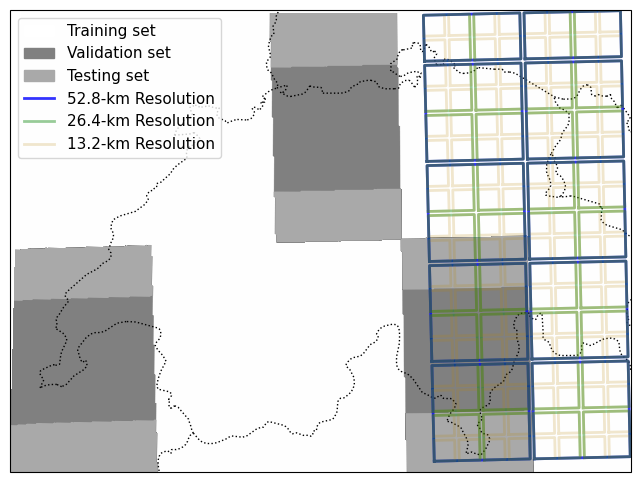

In [11]:
colors = ["white", "gray", "darkgray"]

col = 'Position'
custom_cmap = LinearSegmentedColormap.from_list(
    "gray_blue_green", 
    colors
)

lat_vals = np.linspace(df['lat'].min(), df['lat'].max(), 500)
lon_vals = np.linspace(df['lon'].min(), df['lon'].max(), 500)
grid_lat, grid_lon = np.meshgrid(lat_vals, lon_vals)

grid_loc_pred = griddata(
    (df['lat'], df['lon']),  
    df[col],         
    (grid_lat, grid_lon),   
    method='nearest'         
)

# Map Baseline
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': LambertConformal(central_longitude=8, central_latitude=46.8)}
)

ax.set_extent([df['lon'].min(), df['lon'].max(), df['lat'].min(), df['lat'].max()], crs=ccrs.PlateCarree())


# Add the splits (Train, Val, Test)
c = ax.contourf(
    grid_lon, grid_lat, grid_loc_pred, 
    levels=np.linspace(1, 3, 100),  
    cmap=custom_cmap,  
    transform=ccrs.PlateCarree()
)

# Display grids at different resolutions 
for numero_block48 in [17, 16, 29, 28, 22, 23, 10, 11, 4, 5] : # Blocks on the right 
    square_coords = get_square_coords(df_topo48, numero_block48)
    square_lats, square_lons = zip(*square_coords)

    ax.plot(
        square_lons, square_lats,
        color='blue', linewidth=2,
        transform=ccrs.PlateCarree(),
        alpha = 0.8
    )

    df_local = df_topo48.loc[df_topo48.block == numero_block48].copy()
    df_local = df_local[['rlat', 'rlon', 'lat', 'lon']]
    df_local = pd.merge(df_local, df_topo24,
                        on = ['rlat', 'rlon', 'lat', 'lon'],
                        how = 'left')
    
    for numero_block24 in df_local.block.unique() :
        square_coords = get_square_coords(df_topo24, numero_block24)
        square_lats, square_lons = zip(*square_coords)

        ax.plot(
            square_lons, square_lats,
            color='green', linewidth=2,
            transform=ccrs.PlateCarree(),
            alpha = 0.4
        )

        df_local = df_topo24.loc[df_topo24.block == numero_block24].copy()
        df_local = df_local[['rlat', 'rlon', 'lat', 'lon']]
        df_local = pd.merge(df_local, df_topo12,
                            on = ['rlat', 'rlon', 'lat', 'lon'],
                            how = 'left')
        
        for numero_block12 in df_local.block.unique() :
            square_coords = get_square_coords(df_topo12, numero_block12)
            square_lats, square_lons = zip(*square_coords)

            ax.plot(
                square_lons, square_lats,
                color='darkgoldenrod', linewidth=2,
                transform=ccrs.PlateCarree(),
                alpha = 0.2
            )



ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.savefig("Fig_3(1).pdf", bbox_inches='tight')

# Legends 
legend_patches = [
    mpatches.Patch(color=colors[0], label="Training set"),
    mpatches.Patch(color=colors[1], label="Validation set"),
    mpatches.Patch(color=colors[2], label="Testing set")
]

legend_lines = [
    Line2D([0], [0], color='blue', linewidth=2, label="52.8-km Resolution", alpha = 0.8),
    Line2D([0], [0], color='green', linewidth=2, label="26.4-km Resolution", alpha=0.4),
    Line2D([0], [0], color='darkgoldenrod', linewidth=2, label="13.2-km Resolution", alpha=0.2)
]

ax.legend(handles=legend_patches + legend_lines, loc="upper left", fontsize=11)
plt.savefig("Figures_End/Fig_3.pdf", format='pdf')
plt.show()


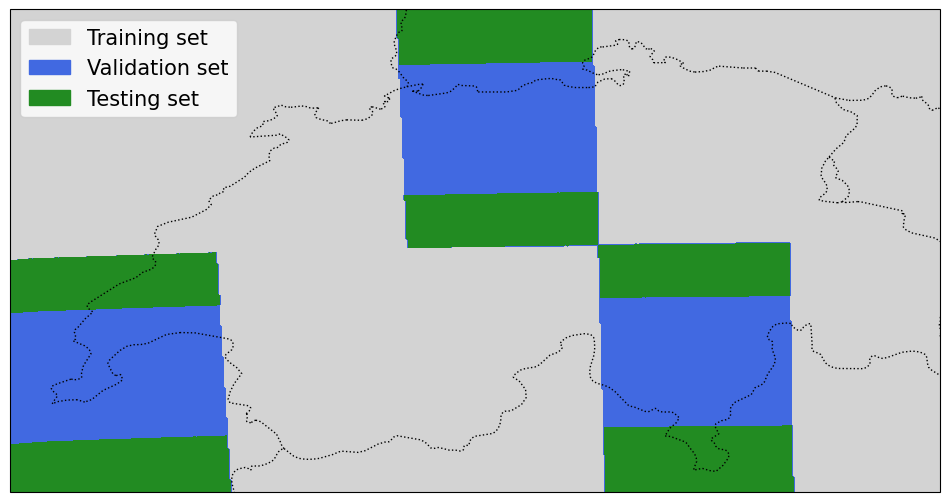

In [12]:
colors = ["lightgray", "royalblue", "forestgreen"]
cmap = ListedColormap(colors)
bounds = [0.5, 1.5, 2.5, 3.5] 
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(
    figsize=(12, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

lat_vals = np.linspace(df['lat'].min(), df['lat'].max(), 500)
lon_vals = np.linspace(df['lon'].min(), df['lon'].max(), 500)
grid_lat, grid_lon = np.meshgrid(lat_vals, lon_vals)

grid_loc_pred = griddata(
    (df['lat'], df['lon']),
    df['Position'],
    (grid_lat, grid_lon),
    method='nearest'
)

c = ax.contourf(
    grid_lon, grid_lat, grid_loc_pred, 
    levels=[0.5, 1.5, 2.5, 3.5],
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree()
)


ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

legend_labels = ["Training set", "Validation set", "Testing set"]
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(3)]
ax.legend(handles=patches, loc="upper left", fontsize=15)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


## 2. Exploration of Precipitation Data

**Objective:** Gain initial insights and better understand precipitation patterns.  

**Input:** data/0_cluster/TOT_PR 

To achieve this, we will analyze and compare multiple spatial resolutions (2.2, 13.2, 26.4, 52.8 km) across two different time periods. This will help assess how precipitation extremes vary, and identify potential biases or trends in the data.


In [13]:
# Downloading the data

dico_df = {}
for time in ['present', 'future']:
    for res in ['HR', 'LR12', 'LR24', 'LR48']:
        dico_df[time+res] = pd.read_csv('data/0_cluster/TOT_PR/data2_summer_'+time+'_'+res+'_v1.csv',
                                        low_memory=False)

dico_df[time+res].head(5)

,block,TOT_PR,time,year,month,index,to_change,constraint_begin,constraint_end,level_0
0,0,0.001814,2079-06-27 05:00:00,2079,6,0,0,NaN,NaN,NaN
1,1,0.001538,2079-06-02 22:00:00,2079,6,1,0,NaN,NaN,NaN
2,2,0.003168,2079-06-27 16:00:00,2079,6,2,0,NaN,NaN,NaN
3,3,0.003772,2079-06-02 15:00:00,2079,6,3,0,NaN,NaN,NaN
4,4,0.002660,2079-06-27 18:00:00,2079,6,4,0,NaN,NaN,NaN


<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_2104/120630017.py:53: SyntaxWarning: invalid escape sequence '\m'
  fig.text(-0.01, 0.5, 'Probability Density (in $\mathrm{h. mm^{-1}}$)', va='center', ha='center', rotation='vertical', fontsize=size)


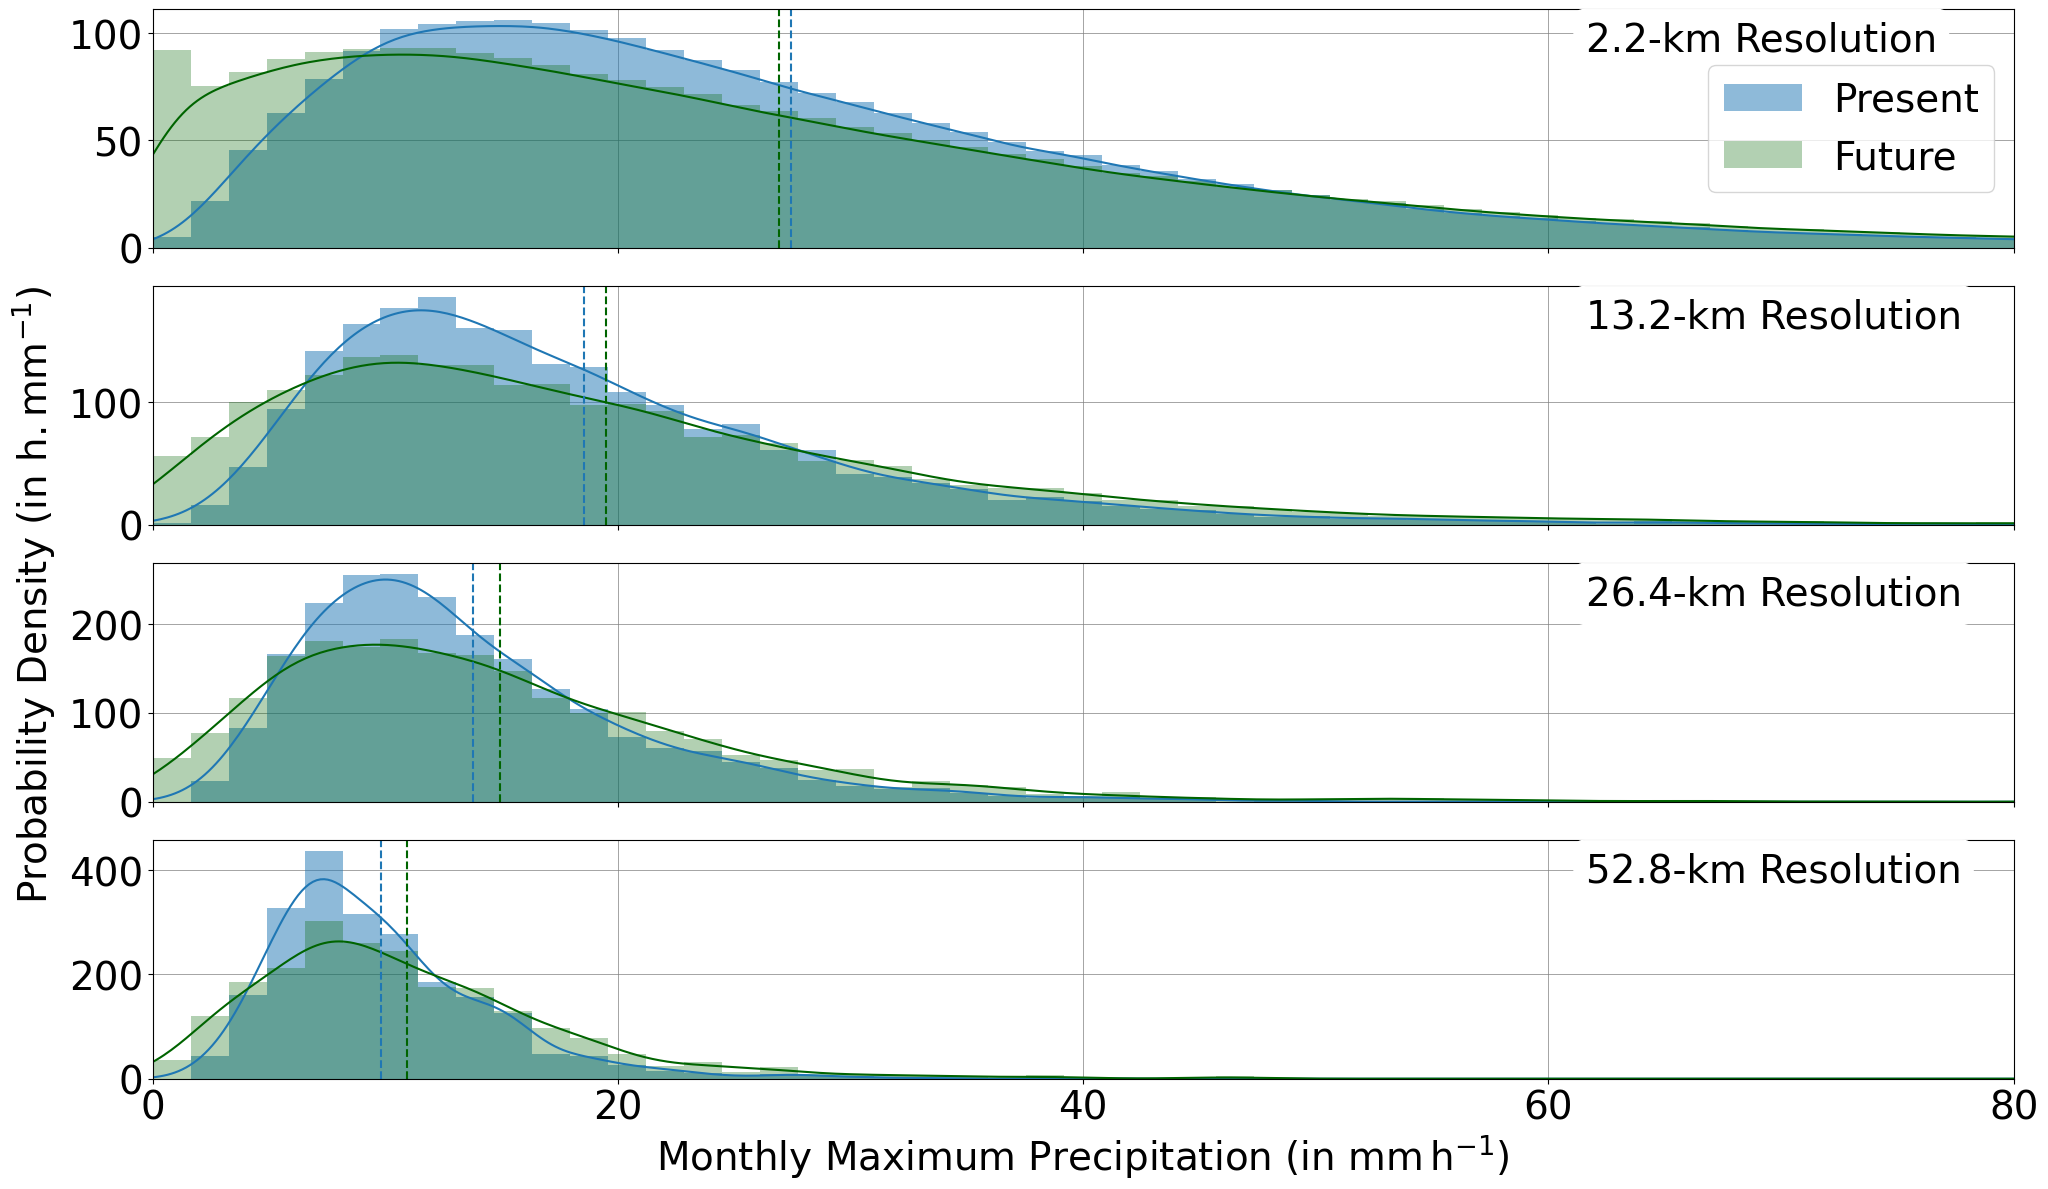

In [20]:
size = 28

# Global parameters
categories = ['HR', 'LR12', 'LR24', 'LR48']
resolutions = ['2.2-km Resolution', '13.2-km Resolution', '26.4-km Resolution', '52.8-km Resolution']
x_limits = (0, 80/3600)


fig, axs = plt.subplots(len(categories), 1, figsize=(20, 12), sharex=True)

for i, (category, resolution) in enumerate(zip(categories, resolutions)):
    ax = axs[i]
    
    present_data = dico_df[f'present{category}']['TOT_PR']
    future_data = dico_df[f'future{category}']['TOT_PR']

    # Density curves
    kde_present = gaussian_kde(present_data)
    kde_future = gaussian_kde(future_data)
    x_vals = np.linspace(x_limits[0], x_limits[1], 500)
    ax.plot(x_vals, kde_present(x_vals), color='#1f77b4')
    ax.plot(x_vals, kde_future(x_vals), color='#006400')
    
    # Plot histograms
    bins = np.linspace(x_limits[0], x_limits[1], 50)
    ax.hist(present_data, bins=bins, alpha=0.5, density=True, label='Present' if i == 0 else None, color='#1f77b4')
    ax.hist(future_data, bins=bins, alpha=0.3, density=True, label='Future' if i == 0 else None, color='#006400')
    
    # Add vertical lines for means
    present_mean = np.mean(present_data)
    future_mean = np.mean(future_data)
    ax.axvline(present_mean, color='#1f77b4', linestyle='--')
    ax.axvline(future_mean, color='#006400', linestyle='--')
    
    # Limits and annotations
    ax.set_xlim(x_limits)
    if i == len(categories) - 1:
        ax.set_xlabel(r'Monthly Maximum Precipitation (in $\mathrm{mm\, h^{-1}}$)', fontsize=size)
    if i == 0:
        ax.legend(fontsize=size)

    ax.text(0.77, 0.95, resolution, transform=ax.transAxes, fontsize=size,
            verticalalignment='top', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round'))
    
    ax.set_axisbelow(True)
    ax.grid(visible=True, color='gray', linestyle='-', linewidth=0.5)
    
    # Transform x-axis tick labels
    ax.set_xticks(np.linspace(x_limits[0], x_limits[1], 5))
    ax.tick_params(axis='both', which='major', labelsize=size)
    ax.set_xticklabels([f'{int(x * 3600)}' for x in np.linspace(x_limits[0], x_limits[1], 5)])

fig.text(-0.01, 0.5, 'Probability Density (in $\mathrm{h. mm^{-1}}$)', va='center', ha='center', rotation='vertical', fontsize=size)


plt.rc('axes', titlesize=size)
plt.rc('axes', labelsize=size)
plt.rc('xtick', labelsize=size)
plt.rc('ytick', labelsize=size)
plt.tight_layout()
plt.savefig("Figures_End/Fig_2.pdf", bbox_inches='tight')
plt.show()


## 3. Analysis of GEV Parameters

### 3.1. Across the domain 
**Objective:** Gain initial insights and better understand precipitation patterns by analyzing the fitted GEV parameters. 

**Input:** data/0_cluster/TOT_PR 

To achieve this, we will analyze and compare multiple spatial resolutions (6, 12, 24, 48 km) across two different time periods. This will help assess how precipitation extremes vary, and identify potential biases or trends in the data.

In [52]:
# Downloading the data

dico_df = {}
for time in ['present', 'future']:
    for res in ['', '12', '24', '48']:
        dico_df[time+res] = pd.read_csv('data/2_True_Parameters/gev2_param_true_'+time+res+'.csv',
                                        low_memory=False)

dico_df[time+res].head(5)

,block,loc,scale,shape
0,1,0.001967,0.000865,-0.027039
1,2,0.002122,0.000882,-0.087949
2,3,0.001897,0.001158,-0.051911
3,4,0.001887,0.001186,0.100041
4,5,0.002291,0.001398,0.013242


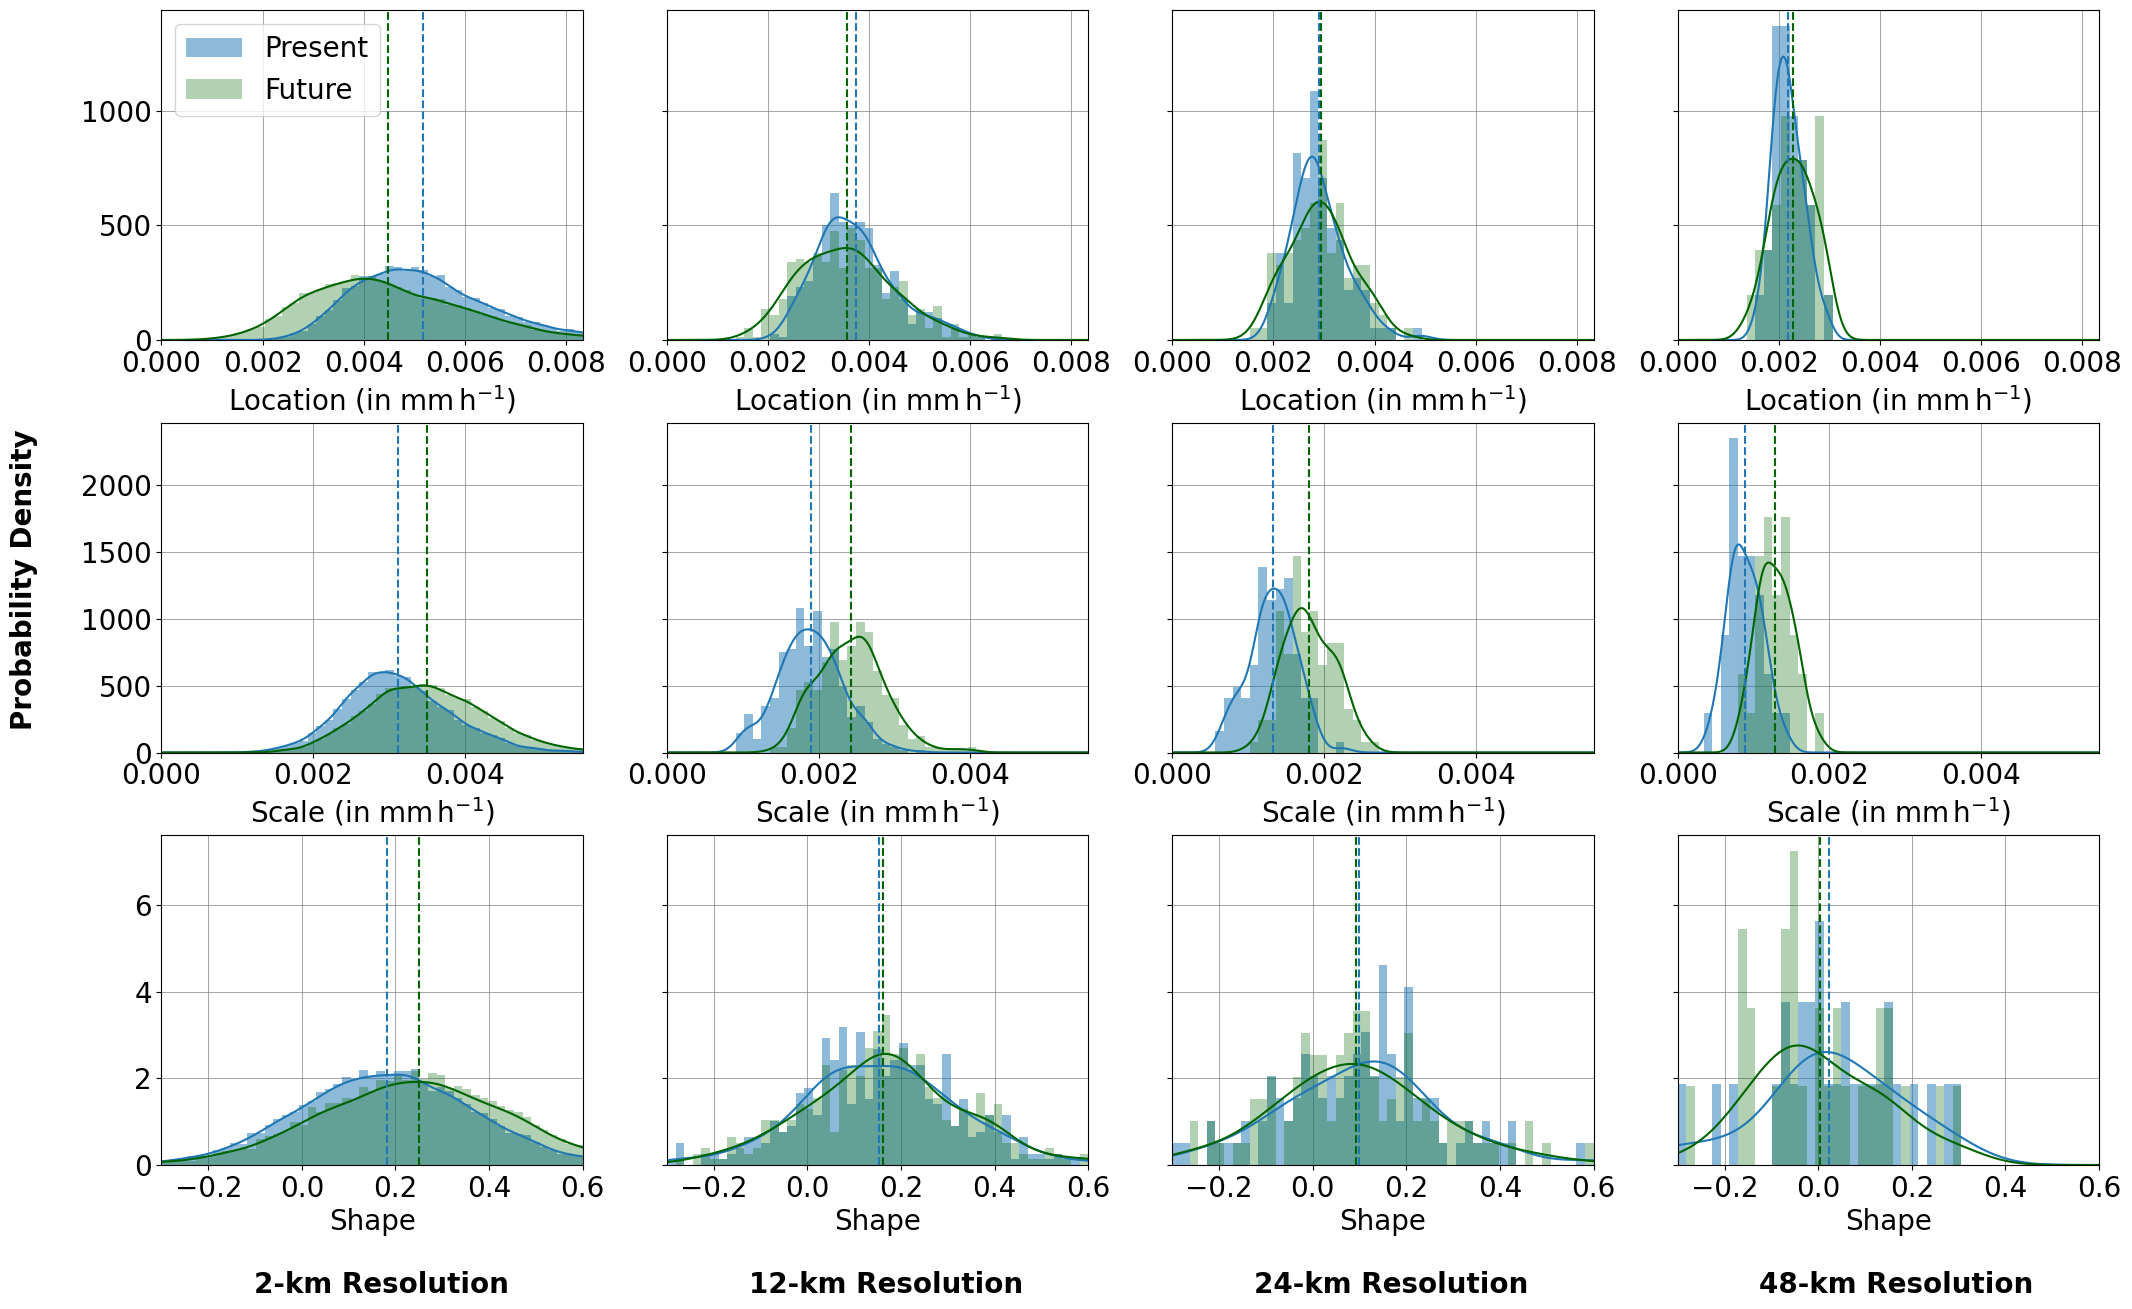

In [ ]:
size = 20

# Global parameters
categories = ['', '12', '24', '48']
resolutions = ['2-km Resolution', '12-km Resolution', '24-km Resolution', '48-km Resolution']
parameters = ['loc', 'scale', 'shape']
x_limits = {
    'loc': (0, 30/3600),
    'scale': (0, 20/3600),
    'shape': (-0.3, 0.6)
}

plt.rcParams.update({
    'xtick.labelsize': size,
    'ytick.labelsize': size,
    'legend.fontsize': size,
    'axes.labelsize': size,
    'axes.titlesize': size
})

fig, axs = plt.subplots(len(parameters), len(categories), figsize=(25, 15), sharey='row')

for i, param in enumerate(parameters):  # rows
    for j, (category, resolution) in enumerate(zip(categories, resolutions)):  # columns
        ax = axs[i, j]

        present_data = dico_df[f'present{category}'][param]
        future_data = dico_df[f'future{category}'][param]

        # KDE curves
        kde_present = gaussian_kde(present_data)
        kde_future = gaussian_kde(future_data)
        x_vals = np.linspace(*x_limits[param], 500)
        ax.plot(x_vals, kde_present(x_vals), color='#1f77b4')
        ax.plot(x_vals, kde_future(x_vals), color='#006400')

        # Histograms
        bins = np.linspace(*x_limits[param], 50)
        ax.hist(present_data, bins=bins, alpha=0.5, density=True, label='Present' if i == 0 and j == 0 else None, color='#1f77b4')
        ax.hist(future_data, bins=bins, alpha=0.3, density=True, label='Future' if i == 0 and j == 0 else None, color='#006400')

        # Mean lines
        ax.axvline(np.mean(present_data), color='#1f77b4', linestyle='--')
        ax.axvline(np.mean(future_data), color='#006400', linestyle='--')

        # Axis settings
        ax.set_xlim(x_limits[param])

        xlabel = {
                'loc': r'Location (in $\mathrm{mm\, h^{-1}}$)',
                'scale': r'Scale (in $\mathrm{mm\, h^{-1}}$)',
                'shape': r'Shape'
            }
        ax.set_xlabel(xlabel[param], fontsize=size)

        ax.set_axisbelow(True)
        ax.grid(True, color='gray', linestyle='-', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=size)


# Labels
fig.text(0.07, 0.5, 'Probability Density', va='center', ha='center', rotation='vertical', fontsize=size, fontweight='bold')
fig.text(0.213, 0.03, '2-km Resolution', va='center', ha='center', fontsize=size, fontweight='bold')
fig.text(0.415, 0.03, '12-km Resolution', va='center', ha='center', fontsize=size, fontweight='bold')
fig.text(0.617, 0.03, '24-km Resolution', va='center', ha='center', fontsize=size, fontweight='bold')
fig.text(0.819, 0.03, '48-km Resolution', va='center', ha='center', fontsize=size, fontweight='bold')

# Add legend
axs[0, 0].legend(fontsize=size)

plt.subplots_adjust(hspace=0.25, wspace=0.2)
plt.show()


### 3.2. At a specific Grid Point

**Objective:** Examine the shape and behavior of fitted GEV distributions at a specific location to gain a more detailed understanding of how precipitation extremes are modeled at the local scale.

Input: data/0_cluster/TOT_PR

We focus here on a selected grid point and analyze the corresponding GEV distributions across different spatial resolutions (6, 12, 24, 48 km) and time periods. This localized analysis allows us to visually and statistically assess how distributional properties—such as location, scale, and shape—are affected by resolution changes, and to what extent local precipitation extremes are preserved or altered.

## 4. Topographic Variables

**Objective:** Generate relevant topographic features for each high-resolution grid point. 
 
This involves computing the mean altitude within different radii ranging from 10 to 100 km, as well as the standard deviation of altitude within the same radii. These variables will provide key information on terrain influence, which may help improve the modeling of precipitation patterns.


**Input:** _data/0_cluster/Topography/coordinate_transformer.csv_

**Output:** _data/0_cluster/Topography/topography_variables.csv_


In [2]:
df_topo = pd.read_csv('data/0_cluster/Topography/coordinate_transformer.csv')
df_topo.head(5)

,rlat,rlon,lat,lon,alt
0,-1.2,-2.84,45.726242,5.930880,439.57074
1,-1.2,-2.82,45.727276,5.959485,451.95310
2,-1.2,-2.80,45.728306,5.988092,626.46466
3,-1.2,-2.78,45.729324,6.016699,990.02850
4,-1.2,-2.76,45.730335,6.045307,1105.49220


In [3]:
for DIST in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    df_topo['alt_mean'+str(DIST)] = -1.0
    df_topo['alt_std'+str(DIST)] = -1.0

    for i, row in tqdm.tqdm(df_topo.iterrows()):
        df_topo['distance'] = np.sqrt((df_topo['rlat'] - row['rlat'])**2 + (df_topo['rlon'] - row['rlon'])**2)
        df_topo.loc[i, 'alt_mean'+str(DIST)] = np.mean(df_topo.loc[df_topo['distance'] < DIST * 0.01, 'alt'])
        df_topo.loc[i, 'alt_std'+str(DIST)] = np.std(df_topo.loc[df_topo['distance'] < DIST * 0.01, 'alt'])
        
df = df_topo.copy()
df_topo.drop(columns = ['distance', 'lat', 'lon'], inplace = True)  
df_topo.to_csv('data/0_cluster/Topography/topography_variables.csv', index = False)    

for lat in df.rlat.unique(): df.loc[df.rlat == lat, 'lat'] = np.mean(df.loc[df.rlat == lat, 'lat'])
for lon in df.rlon.unique(): df.loc[df.rlon == lon, 'lon'] = np.mean(df.loc[df.rlon == lon, 'lon'])


0it [00:00, ?it/s]

15552it [00:05, 2655.78it/s]
15552it [00:06, 2582.37it/s]
15552it [00:06, 2548.76it/s]
15552it [00:06, 2533.12it/s]
15552it [00:06, 2547.45it/s]
15552it [00:06, 2503.37it/s]
15552it [00:06, 2469.75it/s]
15552it [00:06, 2433.19it/s]
15552it [00:06, 2411.02it/s]
15552it [00:06, 2386.50it/s]


In [4]:
df.head(5)

,rlat,rlon,lat,lon,alt,alt_mean10,alt_std10,distance,alt_mean20,alt_std20,...,alt_mean60,alt_std60,alt_mean70,alt_std70,alt_mean80,alt_std80,alt_mean90,alt_std90,alt_mean100,alt_std100
0,-1.2,-2.84,45.775491,5.849198,439.57074,574.081677,194.784373,3.572002,667.516927,272.476557,...,918.330037,459.532696,1032.692278,595.099622,1119.875298,655.539173,1157.563041,668.820141,1159.682346,675.089149
1,-1.2,-2.82,45.775491,5.878375,451.95310,615.530615,217.150647,3.556009,655.307063,263.821887,...,942.703447,491.682364,1052.828717,610.086712,1139.408656,670.159331,1157.299009,670.780484,1170.906620,680.362743
2,-1.2,-2.80,45.775491,5.907553,626.46466,675.676831,253.657278,3.540056,660.034037,256.780856,...,967.776208,523.602511,1071.526739,621.864671,1156.658593,680.107779,1159.535087,674.590995,1183.111555,686.479390
3,-1.2,-2.78,45.775491,5.936732,990.02850,736.057244,287.071309,3.524145,685.457987,278.327200,...,993.314913,556.276120,1091.945719,636.423478,1170.031007,684.139961,1163.405704,680.201211,1195.722815,693.918913
4,-1.2,-2.76,45.775491,5.965912,1105.49220,792.403079,293.789929,3.508276,712.863620,299.101555,...,1019.900280,588.311925,1113.878465,653.505499,1178.403285,684.805072,1169.311104,686.700996,1208.431507,702.726435


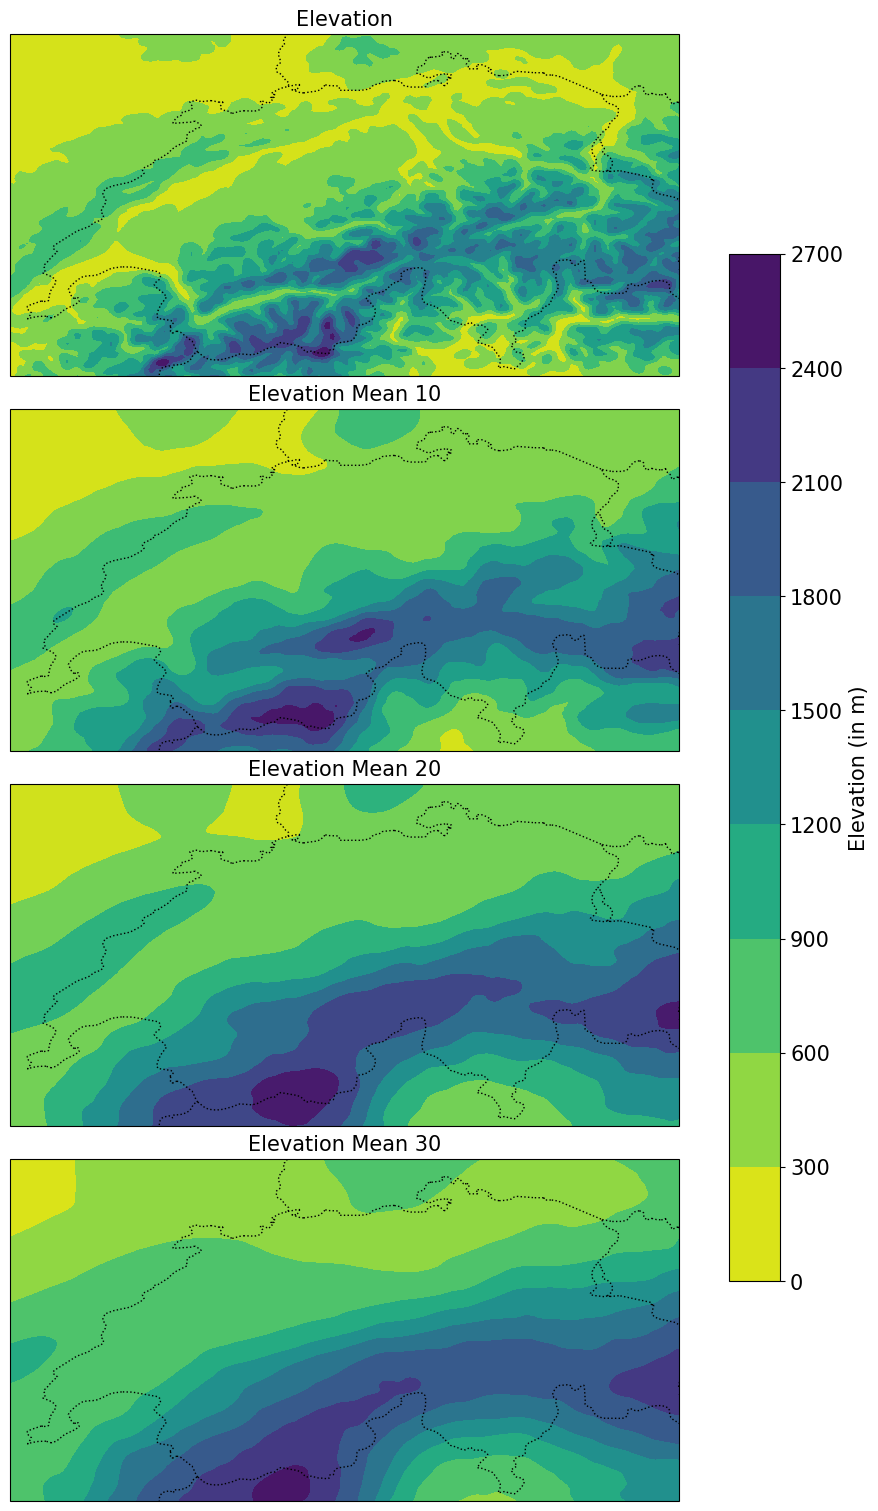

In [ ]:
text_size = 15

# PARAMS for the maps 
number = [10, 20, 30]
columns = ['alt', 'alt_mean'+str(number[0]), 'alt_mean'+str(number[1]), 'alt_mean'+str(number[2])]
titles = [
    'Elevation',
    'Elevation Mean ' +str(number[0]),
    'Elevation Mean ' +str(number[1]),
    'Elevation Mean ' +str(number[2])
]


# Figure 
lon_vals = np.linspace(df['lon'].min(), df['lon'].max(), 200)
lat_vals = np.linspace(df['lat'].min(), df['lat'].max(), 200)
grid_lon, grid_lat = np.meshgrid(lon_vals, lat_vals)


fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(12, 15),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
)

cbar_handle = None


for ax, col, title in zip(axes, columns, titles):

    grid_linear = griddata(
        (df['lat'], df['lon']),
        df[col],
        (grid_lat, grid_lon),
        method='linear'
    )

    c = ax.contourf(
        grid_lon, grid_lat, grid_linear, 
        cmap="viridis_r",
        #levels=np.linspace(df.alt.min(), df.alt.max(), 1000),
        transform=ccrs.PlateCarree()
    )
    cbar_handle = c 

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(title, fontsize=text_size)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

if cbar_handle is not None:
    cbar = fig.colorbar(
        cbar_handle, ax=axes, location='right',
        shrink=0.7, pad=0.05, aspect=20
    )
    cbar.set_label("Elevation (in m)", fontsize=text_size)
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))
    cbar.ax.tick_params(labelsize=text_size) 

plt.show()


## 5. Data Preparation

**Objective:** Structure and preprocess the dataset for model training. 
 
We will split the data into training, validation, and test sets to ensure a robust evaluation of the models. Proper data partitioning is essential to avoid data leakage and ensure that models generalize well to unseen conditions.

**Input:** 
- _data/0\_cluster/Topography/topography\_variables.csv_
- _data/0\_cluster/Topography/train\_validation\_test\_splits.csv_
- _data/0\_cluster/TOT\_PR\_wc/data2\_summer\_present\_HR\_v1.csv_
- _data/0\_cluster/Topography/grille2\_[6, 12, 24, 48].csv_
- _data/2\_True_Parameters/gev2_param_true_present[6, 12, 24, 48].csv_

**Output:** 
- _1\_rework/data[f]2\_[6, 12, 24, 48].csv_
- _1\_rework/data[f]2\_[6, 12, 24, 48]\_rework[f].csv_

In [2]:
period = 'future'

if period == 'present' : note = ''
elif period == 'future' : note = 'f'
else : print('ERROR')

In [ ]:
for resolution in tqdm.tqdm([6, 12, 24, 48]):

    df = pd.read_csv('data/0_cluster/TOT_PR/data2_summer_'+period+'_HR_v1.csv', low_memory=False)[['rlat', 'rlon', 'TOT_PR', 'year', 'month']]
    df_topography = pd.read_csv('data/0_cluster/Topography/grille2_'+str(resolution)+'.csv')[['rlat', 'rlon', 'block', 'block1', 'block2']]
    df = pd.merge(df, df_topography, on = ['rlat', 'rlon'], how = 'left')

    # Add topgraphy variables 
    df_topography = pd.read_csv('data/0_cluster/Topography/topography_variables.csv')[['rlat', 'rlon', 'alt', 'alt_mean50', 'alt_std50']]
    df = pd.merge(df, df_topography, on = ['rlat', 'rlon'], how = 'left')

    # Add low resolution variables 
    for i in range(1, 3):
        df_low_res = pd.read_csv('data/2_True_Parameters/gev2_param_true_'+period+str(resolution)+'.csv')
        df_low_res.rename(columns = {'loc' : 'loc'+str(i), 'scale' : 'scale'+str(i), 'shape' : 'shape'+str(i),
                                    'block' : 'block'+str(i)}, inplace = True)
        df = pd.merge(df, df_low_res, on = ['block'+str(i)], how = 'left')

    df_splits = pd.read_csv('data/0_cluster/Topography/train_validation_test_splits.csv')[['rlat', 'rlon', 'Test', 'Val']]
    df = pd.merge(df, df_splits, on = ['rlat', 'rlon'], how = 'left')
    df.drop_duplicates(inplace = True)

    df.drop(columns = ['block1', 'block2'], inplace = True)
    df.to_csv('data/1_rework/data'+note+'2_'+str(resolution)+'.csv', index = False)

del df_topography, df_low_res, df_splits

100%|██████████| 2/2 [00:13<00:00,  6.53s/it]


In [4]:
for resolution in tqdm.tqdm([24, 48]):
    cols_name = ['loc1', 'scale1', 'shape1',
             'loc2', 'scale2', 'shape2',
             'alt', 'alt_mean50', 'alt_std50']

    # Initialization 
    df = pd.read_csv('data/1_rework/data'+note+'2_'+str(resolution)+'.csv')
    df_train = df.loc[(df.Test == 0) & (df.Val == 0)].copy()

    df_infos = {}
    for col in cols_name :
        df_infos[col] = [np.mean(df_train[col]), np.std(df_train[col])]
        df[col] = (df[col] -  df_infos[col][0])/df_infos[col][1]
    cols_name += ['rlon', 'rlat', 'Test', 'Val', 'TOT_PR']
    df = df[cols_name]

    df = pd.merge(df, pd.read_csv('data/2_True_Parameters/gev2_param_true_'+period+'.csv')[['loc', 'shape', 'scale', 'rlon', 'rlat']],
                on = ['rlon', 'rlat'], how = 'left')

    df.to_csv('data/1_rework/data'+note+'2_'+str(resolution)+'_rework'+note+'.csv', index = False)


100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


In [ ]:
# NORMALISATION PAR RAPPORT AU PRESENT 

df = pd.read_csv('data/1_rework/data2_48.csv')
dff = pd.read_csv('data/1_rework/dataf2_48.csv')

df_train = df.loc[(df.Test == 0) & (df.Val == 0)].copy()

cols_name = ['loc1', 'scale1', 'shape1', 
             'loc2', 'scale2', 'shape2', 
             'alt', 'alt_mean50', 'alt_std50']

df_infos = {}
for col in cols_name :
    df_infos[col] = [np.mean(df_train[col]), np.std(df_train[col])]
    df[col] = (df[col] -  df_infos[col][0])/df_infos[col][1]
    dff[col] = (dff[col] -  df_infos[col][0])/df_infos[col][1]

cols_name += ['rlon', 'rlat', 'Test', 'Val', 'TOT_PR']
df = df[cols_name]
dff = dff[cols_name]
print(df.isna().mean())
print(dff.isna().mean())

df = pd.merge(df, pd.read_csv('data/2_True_Parameters/gev2_param_true_present.csv')[['loc', 'shape', 'scale', 'rlon', 'rlat']],
              on = ['rlon', 'rlat'], how = 'left')

dff = pd.merge(dff, pd.read_csv('data/2_True_Parameters/gev2_param_true_future.csv')[['loc', 'shape', 'scale', 'rlon', 'rlat']],
              on = ['rlon', 'rlat'], how = 'left')


#df.to_csv('data/1_rework/data2_24_rework.csv', index = False)
dff.to_csv('data/1_rework/dataf2_48_rework.csv', index = False)

loc1          0.0
scale1        0.0
shape1        0.0
loc2          0.0
scale2        0.0
shape2        0.0
alt           0.0
alt_mean50    0.0
alt_std50     0.0
rlon          0.0
rlat          0.0
Test          0.0
Val           0.0
TOT_PR        0.0
dtype: float64
loc1          0.0
scale1        0.0
shape1        0.0
loc2          0.0
scale2        0.0
shape2        0.0
alt           0.0
alt_mean50    0.0
alt_std50     0.0
rlon          0.0
rlat          0.0
Test          0.0
Val           0.0
TOT_PR        0.0
dtype: float64
